<a href="https://colab.research.google.com/github/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/blob/main/HRNNModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Necessary imports to configure the environment.

In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import os
import collections
import json
from google.colab import files

SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

Getting the Dataset from the Github repository:

In [ ]:
!wget https://github.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/raw/main/Dataset/P2_measurements.zip
!unzip P2_measurements.zip -d P2_measurements

The Hysteresis Dataset is downloaded from the Github repository and stored into a dictionary. The values of H from the Dataframe are normalized (standard scaling), while the values of B are normalized between 0 and 1.

In [3]:
cwd = "/content/P2_measurements"

# Set the following flag to True to consider the whole Hysteresis Curve, including
# the first Magnetization curve.
include_first_magnetization = True

# The scaler is used to normalize H dataset values
H_scaler = preprocessing.StandardScaler()

# The scaler is used to rescale the B dataset values between 0 and 1
B_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

# Creating a dictionary containing all the measurements divided by frequency
dataset = {}
columns = ["t", "B", "H", "-H"] # t: timestamp, B: Magnetic Flux Density, H: Magnetic Field 

for file in os.listdir(cwd):
    temp_data = pd.read_csv(os.path.join(cwd, file),sep=';', header=None, names=columns)
    # Normalizing the Dataset
    temp_data_norm = pd.DataFrame(H_scaler.fit_transform(temp_data[['H']]), columns=['H']) 
    temp_data_norm['B'] = B_scaler.fit_transform(temp_data[['B']])
    if include_first_magnetization:
        dataset[file] = temp_data_norm
    else:
        # Select only the second half of the curve
        dataset[file] = temp_data_norm[int(len(temp_data)/2):].reset_index(drop=True)

dataset = collections.OrderedDict(sorted(dataset.items(), key=lambda t: t[1].shape, reverse=True))

## Subsampling the curves
Each curve can be subsampled to 200 samples. This pre-processing modifies the sampling frequency of the data, in order to obtain the same amount of samples for each curve, measured for different input frequencies.

In [4]:
# Set to False not to subsample the curves to the same number of samples
subsample = False

subsample_len = 200 if include_first_magnetization else 100

Building the *Training Set*: the curves are subsampled to 200 samples starting from the first sample. The median frequency curve (H at 20 Hz) is excluded from training and used for validation purposes.

In [5]:
train_dataset = collections.OrderedDict()

if subsample:
    for freq in dataset:
        if freq != 'P2_20Hz.CSV':
            train_dataset[freq] = dataset[freq].iloc[np.arange(0, len(dataset[freq]), int(len(dataset[freq])/subsample_len))]
else:
    for freq in dataset:
        if freq != 'P2_20Hz.CSV':
            train_dataset[freq] = dataset[freq]

Building the *Validation Set*: the curves are subsampled to 200 samples starting from half of the subsampling step. The 1 kHz curve is excluded, because it does not contain enough samples to be subsampled multiple times. It includes the 20 Hz curve, subsampled starting from the first sample.

In [6]:
val_dataset = collections.OrderedDict()

if subsample:
    for freq in dataset:
        if freq != 'P2_1kHz.CSV':
            if freq != 'P2_20Hz.CSV': 
                val_dataset[freq] = dataset[freq].iloc[np.arange(int((len(dataset[freq])/subsample_len) / 2), len(dataset[freq]), int(len(dataset[freq])/subsample_len))]
            else:
                val_dataset[freq] = dataset[freq].iloc[np.arange(0, len(dataset[freq]), int(len(dataset[freq])/subsample_len))]
else:
    for freq in dataset:
        if freq == 'P2_20Hz.CSV':
            val_dataset[freq] = dataset[freq]

# HRNN Model Training:

This notebook contains the preliminary tests: different strategies to train the HRNN are here explored, trying to understand how to proceed.

In [7]:
# Defining some of the Network and Sequence parameters:
# For training purposes, the sequence length is fixed to 20
seq_len = 20
batch_size = len(train_dataset)

# To have cross-batch statefulness set stateful = True
stateful = True

Training batches are created according to the following structure:

```
Batch 0 = [sample_0.5Hz_from_t0_to_t20, sample_1Hz_from_t0_to_t20, ..., sample_1kHz_from_t0_to_t20]

Batch 1 = [sample_0.5Hz_from_t20_to_t40, sample_1Hz_from_t20_to_t40, ..., sample_1kHz_from_t20_to_t40]

Batch 2 = ...
```
Each batch contains samples related to different input frequencies, for a total of 11 samples: each sample contains ```seq_len = 20``` timesteps.

The following cell allows to batch also a signal containing the first magnetization curve. The repeated sequences are instead extracted from the portion of the signal which does not contain the first magnetization (namely, the second period of the signal).

In [8]:
"""
This method is used to create batches from the given dictionary of data
:param data: dictionary containing the curves indexed by frequency
:param include_first_magnetization: if True, both the periods of the curve are used,
including the first magnetization
:param repetitions: if greater than one, the curves are repeated multiple times  
in the batches
:param seq_len: it refers to the length of each input sequence in the batch
:param subsampled: it indicates if the input data have been subsampled
:param subsample_len: it indicates the number of samples each curve has been 
subsampled to
"""
def create_batches(data, include_first_magnetization=True, repetitions=1, seq_len=20, subsampled=True, subsample_len=200):

    batches = []

    if subsampled and repetitions == 1:
        curve_max_len = subsample_len
    elif subsampled and repetitions > 1:
        curve_max_len = subsample_len * repetitions
    elif not subsampled:
        curve_max_len = max([x.shape[0] for x in data.values()])

    for i in range(0, curve_max_len, seq_len):
        batch_X = []
        batch_Y = []
        for freq in data:
            half_length = int(len(data[freq]) / 2)

            index = i % len(data[freq])
            repetition = i // len(data[freq])
        
            if include_first_magnetization:
                if repetition < 1:
                    X = np.array(data[freq].iloc[index : index + seq_len][['H']])
                    Y = np.array(data[freq].iloc[index : index + seq_len][['B']])
                else:
                    # The rep_index is used to not exceed the half length "repetition" array
                    rep_index = index % half_length
                    X = np.array(data[freq].iloc[half_length + rep_index : half_length + rep_index + seq_len][['H']])
                    Y = np.array(data[freq].iloc[half_length + rep_index : half_length + rep_index + seq_len][['B']]) 
            else:
                X = np.array(data[freq].iloc[index : index + seq_len][['H']])
                Y = np.array(data[freq].iloc[index : index + seq_len][['B']])
        
            batch_X.append(X)
            batch_Y.append(Y)
    
        batches.append([batch_X, batch_Y])

    return np.array(batches)

In [9]:
# Create the batches to be used for model training
repetitions = 1

train_batches = create_batches(train_dataset, repetitions=repetitions, subsampled=subsample)

# Create the batches to be used for model validation
val_batches = create_batches(val_dataset, repetitions=repetitions, subsampled=subsample)

## Hysteretic RNN Cell Definition:

In [8]:
class HystereticRNNCell(tf.keras.layers.Layer):

    def __init__(self, alpha, beta, chi=None, **kwargs):
        if alpha.shape != beta.shape:
            raise ValueError(f'The dimensions of alpha and beta must be the same: alpha {alpha.shape} vs beta {beta.shape}')
        self.units = len(alpha)
        self.state_size = len(alpha)
        self.alpha = alpha
        self.beta = beta
        self.chi = chi
        if self.chi is None:
            self.chi = 10
        super(HystereticRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='ones',
                                      trainable=False,
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(shape=(self.units,),
                                      initializer='ones',
                                      trainable=False,
                                      name='recurrent_kernel')
        self.built = True
    
    def call(self, inputs, states):
        prev_output = states[0]
        h = tf.keras.backend.dot(inputs, self.kernel)
        prev_output = prev_output * self.recurrent_kernel
        output = (1 - prev_output)/(1 + tf.math.exp((self.alpha - h)*self.chi)) + prev_output/(1 + tf.math.exp((self.beta - h)*self.chi))
        return output, [output]

Defining the "forward" and "reverse" transformation values α and β according to the experiments conducted in the paper "*Hysteretic recurrent neural networks: a
tool for modeling hysteretic materials and
systems*"

In [9]:
beta_diff = [0.02, 0.17, 0.32, 0.47]
alpha_range = np.arange(0, 1.01, 0.01)


alpha = np.tile(alpha_range, len(beta_diff))
beta = []

for diff in beta_diff:
    beta.extend(np.round(alpha_range - diff, 2))

alpha = np.array(alpha)
beta = np.array(beta)

Model: "HRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(10, 20, 1)]             0         
                                                                 
 rnn (RNN)                   (10, 20, 404)             808       
                                                                 
 dense (Dense)               (10, 20, 1)               404       
                                                                 
Total params: 1,212
Trainable params: 404
Non-trainable params: 808
_________________________________________________________________


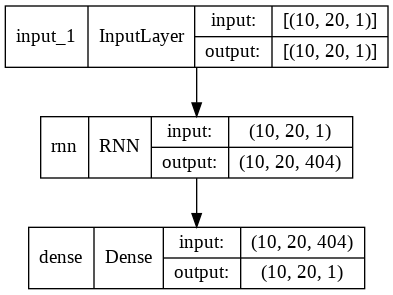

In [12]:
# Example: building a HRNN using the custom cell

cell = HystereticRNNCell(alpha=alpha, beta=beta)

inputs = tf.keras.layers.Input(shape=(seq_len, 1,), batch_size=batch_size)
layer = tf.keras.layers.RNN(cell, return_sequences=True, stateful=stateful)(inputs)
outputs = tf.keras.layers.Dense(1, activation='linear', use_bias=False, kernel_constraint=tf.keras.constraints.UnitNorm())(layer)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='HRNN')
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
# Optimization parameters

# Mean Squared Error for Regression
loss = tf.keras.losses.MSE 
# Learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = [tf.metrics.MeanAbsoluteError()]

In [14]:
# Compile Model
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

## Batch Training (10 sequences per batch, one for each frequency):
The model is trained with a "stateful" HRNN layer.

Weights are tuned after each batch of samples, which include different frequencies.

In [ ]:
# Training over all the dataset:

# Setting the number of training epochs
num_epochs = 10

training_history = {}
validation_history = {}

for epoch in range(num_epochs):
    print('Epoch:' + ' ' + str(epoch+1))
    print('Training...')
    for index, batch in enumerate(train_batches):
        print('\t' + f"Batch {index}:")
        metrics = model.train_on_batch(x=batch[0], y=batch[1], return_dict=True)
        print('\t' + '  ' + 'Loss: ' + str(metrics['loss']))
        print('\t' + '  ' + 'MAE: ' + str(metrics['mean_absolute_error']))
    training_history[epoch] = metrics['loss']
    '''
    print('Validation...')
    for index, batch in enumerate(val_batches):
        print('\t' + f"Batch {index}:")
        metrics = model.test_on_batch(x=batch[0], y=batch[1], return_dict=True)
        print('\t' + '  ' + 'Val_Loss: ' + str(metrics['loss']))
        print('\t' + '  ' + 'Val_MAE: ' + str(metrics['mean_absolute_error']))
    validation_history[epoch] = metrics['loss']
    '''
    if stateful:
        model.reset_states()
print("--------")  

Plot the Training and Validation Loss


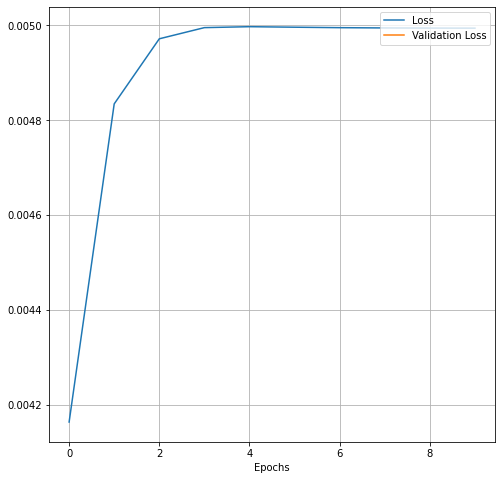

In [17]:
plt.figure(figsize=(8, 8))
plt.grid(True)
plt.xlabel("Epochs")
plt.plot(list(training_history.keys()), list(training_history.values()), label='Loss')
plt.plot(list(validation_history.keys()), list(validation_history.values()), label='Validation Loss')
plt.legend(loc="upper right")
plt.show()

In [ ]:
filename = f'HRNN_{len(alpha)}_units_seq_len_{seq_len}_stateful_{stateful}_first_magnetization_{include_first_magnetization}_subsampling_{subsample}_repeated_{repetitions}_epochs_{num_epochs}.h5'

# Saving the model weights
model.save_weights(filename, save_format='h5')

files.download(filename)

In [19]:
# Store the model weights in a variable
model_weights = model.get_weights()

Model: "HRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(1, 20, 1)]              0         
                                                                 
 rnn (RNN)                   (1, 20, 404)              808       
                                                                 
 dense (Dense)               (1, 20, 1)                404       
                                                                 
Total params: 1,212
Trainable params: 404
Non-trainable params: 808
_________________________________________________________________


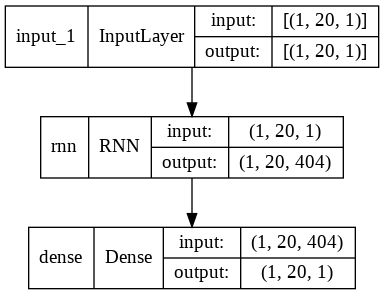

In [10]:
# Instantiating a prediction model to use a different batch size during prediction
batch_size_pred = 1 

cell = HystereticRNNCell(alpha=alpha, beta=beta)

inputs = tf.keras.layers.Input(shape=(seq_len, 1,), batch_size=batch_size_pred)
layer = tf.keras.layers.RNN(cell, return_sequences=True, stateful=stateful)(inputs)
outputs = tf.keras.layers.Dense(1, activation='linear', use_bias=False, kernel_constraint=tf.keras.constraints.UnitNorm())(layer)

prediction_model = tf.keras.Model(inputs=inputs, outputs=outputs, name='HRNN')
prediction_model.summary()

tf.keras.utils.plot_model(prediction_model, show_shapes=True)

Take the weights from the just trained model:

In [21]:
prediction_model.set_weights(model_weights)

# Prediction comparisons:

The following method is used to plot model predictions vs. ground truth, with some additional metrics as MSE and MAE.

In [12]:
prediction_model.load_weights('/content/HRNN_404_units_seq_len_20_stateful_True_first_magnetization_True_subsampling_False_repeated_1_epochs_10.h5')

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.offsetbox import AnchoredText

def plot_prediction(prediction, ground_truth, input_signal, frequency):

    MSE = mean_squared_error(y_true=ground_truth, y_pred=prediction)
    MAE = mean_absolute_error(y_true=ground_truth, y_pred=prediction)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(frequency)

    ax1.set_title('Prediction')
    ax1.scatter(input_signal, prediction)
    ax1.grid(True)
    anchored_text = AnchoredText('MSE:' + str(round(MSE, 6)) + '\n' + 'MAE:' + str(round(MAE, 6)), loc=2)
    ax1.add_artist(anchored_text)

    ax2.set_title('Ground Truth')
    ax2.scatter(input_signal, ground_truth, c='orange')
    ax2.grid(True)

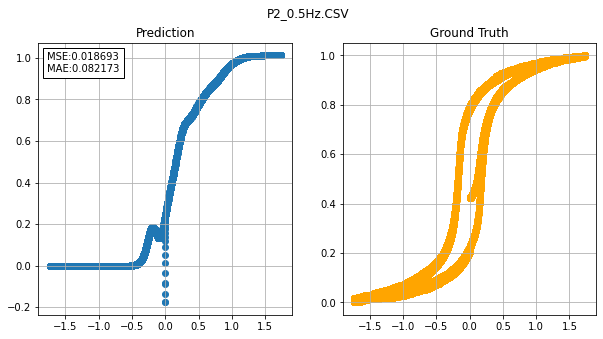

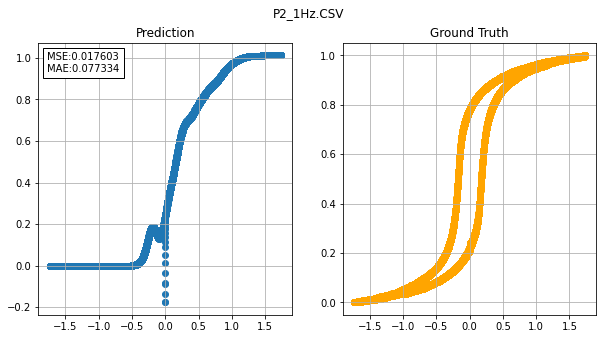

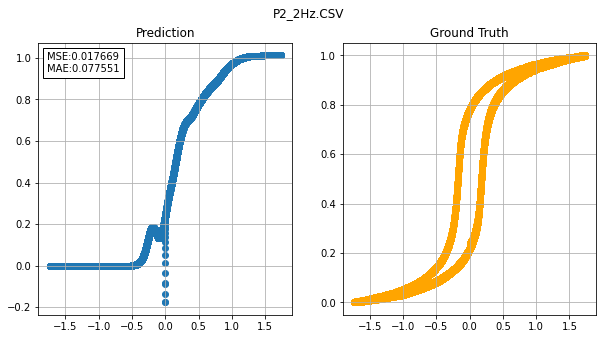

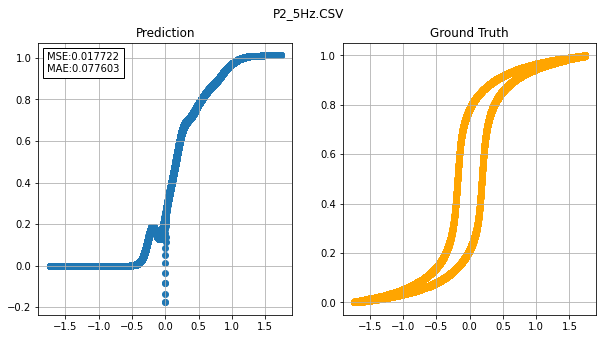

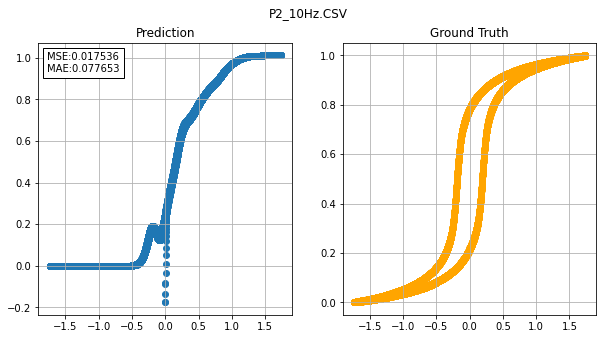

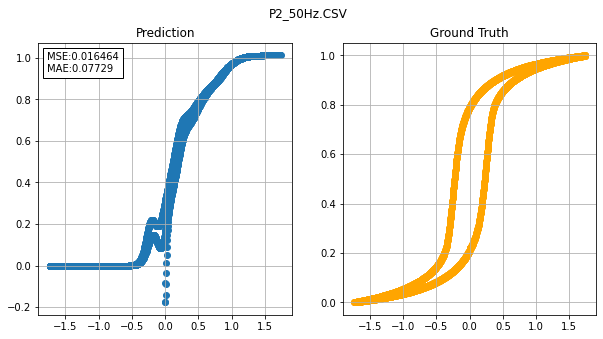

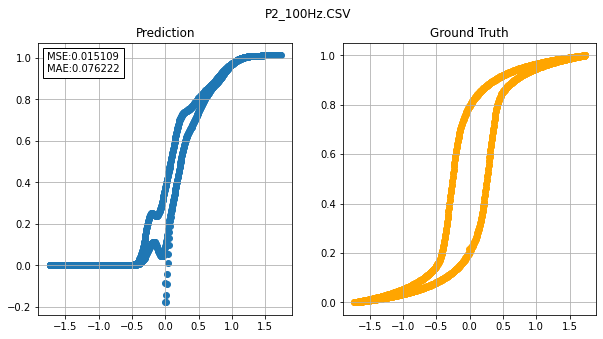

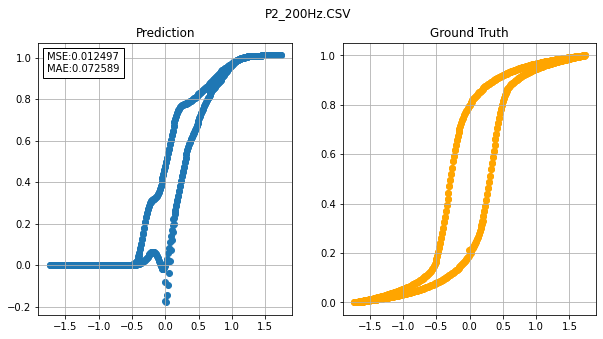

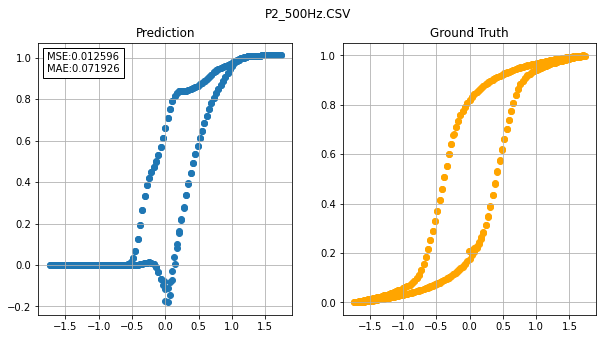

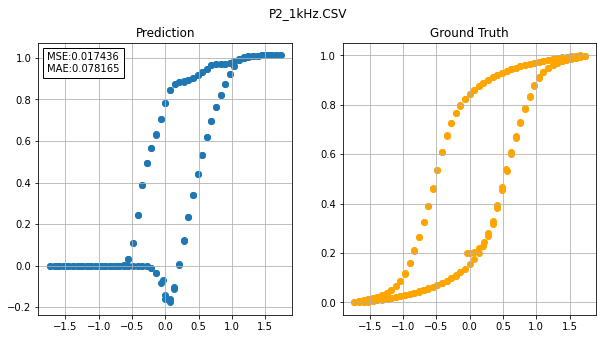

In [13]:
############# DEBUG ###############
## PREDICTIONS OVER TRAINING DATA #

# Testing the model on the validation data, to have an idea of what it is learning
model_predictions = {}
y_pred = []

prediction_model.reset_states()

for freq in train_dataset:
    x_signal = np.array(train_dataset[freq][['H']])
    # Divide the signal in batches
    x = x_signal.reshape(-1, seq_len)
    y_pred = []
    for el in x:
        y_pred.append(prediction_model.predict(np.expand_dims(el, axis=0)))

    # Reshape batch predictions into a single array
    y_pred = np.array(y_pred).reshape(-1, 1)
    y_true = train_dataset[freq]['B']

    # Store predictions into a dict to be written as a file
    model_predictions[freq] = y_pred.tolist()

    # Reset the states after each frequency prediction
    prediction_model.reset_states()
    
    plot_prediction(y_pred, y_true, x_signal, freq)

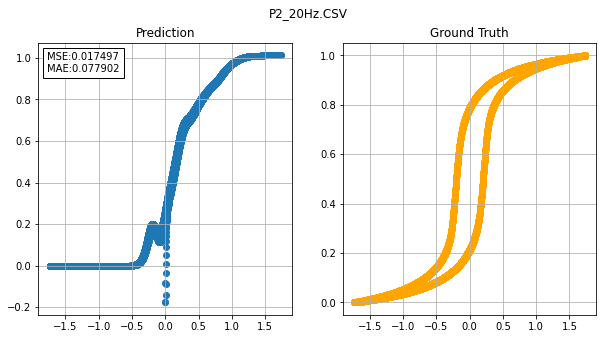

In [15]:
############# DEBUG ###############
#### PREDICTIONS OVER TEST DATA ###

# Testing the model on the validation data, to have an idea of what it is learning
model_predictions = {}
y_pred = []

prediction_model.reset_states()

for freq in val_dataset:
    x_signal = np.array(val_dataset[freq][['H']])
    # Divide the signal in batches
    x = x_signal.reshape(-1, seq_len)
    y_pred = []
    for el in x:
        y_pred.append(prediction_model.predict(np.expand_dims(el, axis=0)))

    # Reshape batch predictions into a single array
    y_pred = np.array(y_pred).reshape(-1, 1)
    y_true = val_dataset[freq]['B']

    # Store predictions into a dict to be written as a file
    model_predictions[freq] = y_pred.tolist()

    # Reset the states after each frequency prediction
    prediction_model.reset_states()
    
    plot_prediction(y_pred, y_true, x_signal, freq)

In [ ]:
#### DEBUG ####
# Write prediction file and save    
with open(filename + '_predictions.txt', 'w') as file:
     file.write(json.dumps(model_predictions))

files.download(filename + '_predictions.txt')